------------------------------------------------------------------------------------------------------------------------

This is the results part of the project. In here functions are declared and described. If you want to see them applied and the results, please go to:

 ### __[Results](https://github.com/serbanradulescu/master_thesis/blob/main/project.ipynb)__ |  Code 
------------------------------------------------------------------------------------------------------------------------

In [1]:
import re
import wget
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms
from IPython.display import display, HTML
from typing import List, Tuple, Optional
from requests_html import HTMLSession
from itertools import combinations
from functools import lru_cache
from zipfile import ZipFile
from os.path import exists
from time import sleep

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
class Parameter:
    def __init__(self, name):
        self.name = name
moisture = Parameter("moisture")
#print(moisture.name)

class Parameters:
    moisture = "moisture"
#print(Parameters.moisture)


In [3]:
@lru_cache #caching the return of the function for time optimisation; not sure if this function is supported in jupyter notebook
def get_links(parameters:tuple[str], time:List[str] = ["1_minute","5_minutes","10_minutes","hourly"]) -> dict:
    """Return the links from dwd corresponding to the parameters and timeframe we are interested

    Args:
        parameters (tuple[str]): a tuple with the parameters
        time (List[str], optional): the timeframe. Defaults to ["1_minute","5_minutes","10_minutes","hourly"].

    Returns:
        dict: a dictionary containing the links
    """
    dwd_links = {interval:{key: None for key in parameters} for interval in time}
    for interval in time:
        for parameter in parameters:
            url = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/' + str(interval) + '/' + parameter + '/historical/'
            try:
                session = HTMLSession()
                response = session.get(url)
                dwd_links[interval][parameter] = response.html.absolute_links

            except requests.exceptions.RequestException as e:
                print(e)
    return dwd_links

In [4]:
def get_date(link:str) -> Tuple[int,int]:
    """Returns the years from when the data is available.

    Args:
        link (str): the link that has included the dails for the available data time

    Returns:
        Tuple[int,int]: start time, end time
    """
    m = re.findall('\d{8}', link)
    if m:
        return (int(m[0][:4]),int(m[1][:4]))
    return (0,0)

In [5]:
def count_datapoints(dwd_links:dict,time,parameter:str, start_year:int, end_year:int) -> int:
    """Counting the datapoints for a certain parameter

    Args:
        dwd_links (dict): source of data (dwd)
        time (_type_): time period (10_minutes, hourly)
        parameter (str): climatic parameters we are interested in
        start_year (int): start of the observation period
        end_year (int): end of the observation period

    Returns:
        int: numbers of datapoints of the parameter that contain the complete period we are interested
    """
    i=0
    for link in dwd_links[time][parameter]:
        try:
            start_interval = int(get_date(link)[0])
            end_interval = int(get_date(link)[1])
            if ((start_interval <= start_year)  & (end_interval >= end_year)):
                i = i+1
        except:
            pass
    return i

In [6]:
def show_available_data(dwd_links:dict,time, parameters: List[str]):
    data_balance = pd.DataFrame(columns = parameters, index = [str(i) + "'s - present" for i in range(1950,2020,10)])
    for parameter in parameters:
        for i in range(1950,2020,10):
            data_balance[parameter][str(i)+ "'s - present"] = count_datapoints(dwd_links,time,parameter, i, 2020)
    display(data_balance)

In [7]:
def ids_datapoints(dwd_links:dict,time:str,parameter:str, start_year:int, end_year:int) -> List[str]:
    """Returns the ids of the weather station that has entries for the parameter in the mentioned timeframe

    Args:
        dwd_links (dict): source of data (dwd)
        time (str): time period (10_minutes, hourly)
        parameter (str): climatic parameters we are interested in
        start_year (int): start of the observation period
        end_year (int): end of the observation period

    Returns:
        List[str]: ids of weather stations that have the parameter that contain the complete period we are interested
    """
    list = []
    for link in dwd_links[time][parameter]:
        try:
            start_interval = int(get_date(link)[0])
            end_interval = int(get_date(link)[1])
            if ((start_interval <= start_year)  & (end_interval >= end_year)):
                id = re.findall("_\d{5}_",str(link))[0]
                ##print("link")
                list.append(id[1:-1])
        except:
            pass
    return list

parameters =("air_temperature","dew_point", "moisture", "precipitation")
dwd_links = get_links(parameters)

In [8]:
"""def common_stations(paramer1:str, parameter2:str, time:str, interval: List[int]):
    print(common_stations)
    print(f"{paramer1} and {parameter2} have the following number of stations that measured in:")
    full_list = []
    for i in interval:
        list1 = ids_datapoints(dwd_links,time,paramer1,i,2020)
        list2 = ids_datapoints(dwd_links,time,parameter2,i,2020)
        list1_as_set = set(list1)
        intersection = list1_as_set.intersection(list2)
        intersection_as_list = List(intersection)
        full_list = full_list + intersection_as_list
        print(str(i) + " - present" + ": " + str(len(intersection_as_list)))        
    return full_list
def complex_common_stations(parameters:List[str],time:str, interval: List[int]):
    ids =[{i:{parameter:ids_datapoints(dwd_links,time,parameter,i,2020)}} for parameter in parameters for i in interval]
    for i in range(0,len(interval)):
        print(ids[i])
    for i in range(2, len(parameters)+1):
        combined = combinations(parameters, i)
        #print(" ".join(str(e) for e in combined) )
        #for j in combined:
            #print(ids)
        #print(set.intersection(*[set(list) for list in p]))       

#complex_common_stations(["moisture", "dew_point", "air_temperature"],"hourly", range(1950,2020,10))
"""
def simple_common_stations(ids_parameter1: List[int],ids_parameter2: List[int]) -> List:
    """Common stations between two parameters

    Args:
        ids_parameter1 (List[int]): ids of the first parameter
        ids_parameter2 (List[int]): ids of the second parameter

    Returns:
        List: a list with the common ids of the parameters
    """
    list1_as_set = set(ids_parameter1)
    intersection = list1_as_set.intersection(ids_parameter2)
    intersection_as_list = list(intersection)
    return intersection_as_list


In [9]:
def create_df(parameter:str,time:str,start_year:int,end_year:int,ids:Optional[str] =None, is_test = True):
    test_count = 0
    if(is_test):
        limit =4
    else:
        limit = 99999
    df = pd.DataFrame()
    for link in dwd_links[time][parameter]:   
        if (test_count <= limit):
            test_count+=1
            filename = str.split(link,"/")[-1]
            # Check if the file is in the time range
            if start_year < get_date(filename)[0] or end_year > get_date(filename)[1]:
                continue
            #Check if the id is in the ID list
            if ids != None:
                id = re.findall("_\d{5}_",str(filename))[0][1:-1]
                if id not in ids:
                    continue
            if(not exists("downloads/" + time + "/" + parameter + "/" + filename)):
                file_zip = wget.download(link,"downloads/"+time+"/" + parameter + "/")
                print("downloading" + filename + "...",end = " ", flush=True)
            else:
                file_zip = "downloads/"+ time+ "/" + parameter + "/" + filename
                #print("FOUND "+ filename, end =" ", flush=True)
            try:    
                with ZipFile(file_zip) as myzip:
                    for filename in myzip.namelist():
                        if "Metadat" not in filename:
                            with myzip.open(filename) as myfile:
                                this_df = pd.read_csv(myfile, sep =";")
                                this_df["STATIONS_ID"] = this_df["STATIONS_ID"].apply(lambda x: str(x).zfill(5))
                                df = pd.concat([df,this_df])
            except:
                print("Not able to open:",filename, "Reason: unknown.")
    #Checking if all given ids were found in the data
    if ids != None:
        if len(list(set(ids) - set(df["STATIONS_ID"].unique()))) ==0:
            print("All given ids accounted for")
        else:
            print("Not found for id(s):", list(set(ids) - set(df["STATIONS_ID"].unique())) )
    if time == "hourly":
        df["year"] = df["MESS_DATUM"].apply(lambda x: str(x)[:4]).astype(int)
        df["month"] = df["MESS_DATUM"].apply(lambda x: str(x)[4:6]).astype(int)
        df["day"] = df["MESS_DATUM"].apply(lambda x: str(x)[6:8]).astype(int)
        df["hour"] = df["MESS_DATUM"].apply(lambda x: str(x)[8:10]).astype(int)
    #Cleaning the white spaces from column names
    df.columns = [col.strip() for col in df.columns]
    #Returning just the years requested
    df = df[df["year"] >= start_year]
    df = df[df["year"] <= end_year]
    return df



In [10]:
def coordinates_stations(ids:List[str], path_info:str ):
    df = pd.read_csv(path_info, header=None, names=["raw"], sep = ";", encoding = "latin1", skiprows=2)
    #df["id"] = df["raw"].apply(lambda x: x[0:5])
    df["id"] = df["raw"].str.extract(r'(\d{5})')
    #df["period"] = df["raw"].str.findall(r'(\d{8})')
    #df["height"] = df["raw"].str.extract(r'(\s+\d{1,3}\s+)')
    df["coord"] = df["raw"].str.findall(r'(\d{1,2}\.{1}\d{4})')
    df[['lat','lon']] = pd.DataFrame(df.coord.tolist(), index= df.index)
    df["lat"]=df["lat"].apply(lambda x: float(x))
    df["lon"]=df["lon"].apply(lambda x: float(x))
    processed_df = df[["id","lat","lon"]]
    if ids == None:
        return processed_df
    else:
        return processed_df[processed_df["id"].isin(ids)]

In [71]:
def plot_points_germany():
    #Preparing the plot
    fig, ax = plt.subplots(figsize=(12,8))
    countries = gpd.read_file( gpd.datasets.get_path("naturalearth_lowres"))
    countries[countries["name"] == "Germany"].plot(color="lightgrey",ax=ax)
    #Plotting for each time range
    for start_year in range(1970,1949,-10):
        moisture_year_h = ids_datapoints(dwd_links,"hourly","moisture",start_year,2020)
        dew_point_year_h = ids_datapoints(dwd_links,"hourly","dew_point",start_year,2020)
        air_temp_year_h = ids_datapoints(dwd_links,"hourly","air_temperature",start_year,2020)

        common_ids = (simple_common_stations(simple_common_stations(moisture_year_h,dew_point_year_h),air_temp_year_h))
        stations_coordinates = coordinates_stations(common_ids,"downloads/hourly/dew_point/TD_Stundenwerte_Beschreibung_Stationen.txt")


        
        sns.scatterplot(x="lon", y="lat",data=stations_coordinates, label = f"{start_year}- 2020")#,title=f"Weather stations that measure the parameters required for applying \n the disease models in the time period of {start_year} - present",  ax=ax)
    
    plt.legend(title = "Available data")
    plt.show()

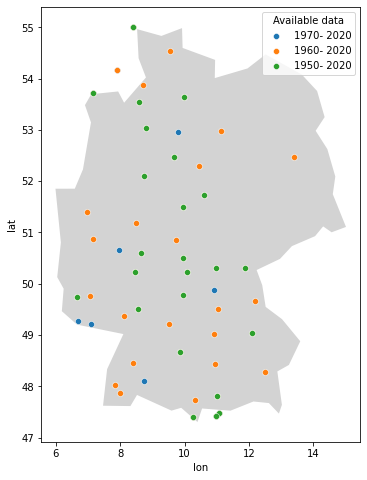

In [72]:
#plot_points_germany()

### Plots

In [74]:
def plot_optimal_temperature(
    df:pd.DataFrame, 
    temp_min:float, temp_max:float, 
    hist_start:float,hist_end:float,
    months: list,
    moving_average: int):

    df["useful_t"] = df.TT_TU.apply(lambda x: 1 if (x >= temp_min and x <= temp_max) else 0)
    df = df[df["month"].isin(months)]
    df= df.groupby(["year"]).mean()
    avg_hist= df[(df.index <= hist_end)&(df.index >= hist_start)]["useful_t"].mean()
    max_hist = df[(df.index <= hist_end)&(df.index >= hist_start)]["useful_t"].max()
    min_hist = df[(df.index <= hist_end)&(df.index >= hist_start)]["useful_t"].min()
    df[f'{moving_average}years_average'] = df.useful_t.rolling(7).mean()
    plt.figure(figsize = (15,8))
    sns.lineplot(x = 'year', y = 'useful_t',data = df, label="yearly optimal hours %", alpha = 0.55)
    sns.lineplot(x = 'year', y = f'{moving_average}years_average',data = df, label=f'{moving_average} years average', color = "orange")
    sns.lineplot(x = df.index, y = min_hist,linestyle="dashed", label=f"minimum in the historical period ({hist_start}-{hist_end})")
    sns.lineplot(x = df.index, y = avg_hist,linestyle="dashed", label=f"average in the historical period ({hist_start}-{hist_end})")
    sns.lineplot(x = df.index, y = max_hist, linestyle="dashed", label=f"maximum period in the historical period ({hist_start}-{hist_end})")
    plt.ylabel("% of hours with optimal temperature")
    #plt.plot([hist_end,hist_end], [-0.00,0.05], lw=2, color = "0.65", label = "historical period (left)")

    plt.figtext(0.15, 0.021, f"Figure 1. Variation of optimal temperature % for Septoria tritici in Germany in the time period of ({hist_start} - {hist_end}). Optimal temperature is considered when air \n temperature is between {temp_min} and {temp_max} degrees Celsius in the months of {months}. " )
    plt.show()



In [ ]:
def plot_lw_RHt(df:pd.DataFrame, 
                thresholds:list[float],
                hist_start:float,hist_end:float,
                months: list,
                moving_average: int,
                hours:list[int]):
    df = df[(df["month"].isin(months))
                &(df["hour"].isin(hours))]
    for i in thresholds:
        df[f"lw{i}"]=df["RF_STD"].apply(lambda x: 1 if float(x) >= i else 0)
    df= df.groupby("year").mean()
    for i in thresholds:
        df[f'lw{i}_7years_average'] = df[f"lw{i}"].rolling(moving_average).mean()
        df[f"avg_hist_lw{i}"]= df[(df.index >= hist_start)&(df.index <= hist_end)][f"lw{i}"].mean()
    plt.figure(figsize = (15,7.5))
    for i in thresholds:
        sns.lineplot( x="year", y = f"lw{i}", data= df, label= f"leaf humidity treshold set at RH = {i}",alpha=0.33)
        sns.lineplot(x = 'year', y = f'lw{i}_7years_average',data = df, label=f'lw{i}_7years_average')
        sns.lineplot(x = "year", y = f"avg_hist_lw{i}",data = df,linestyle="dashed", label=f"{moving_average} years moving average for lw{i}")
    plt.title(f"Leaf wetness for different RH treshold measured in the interval {hours}")
    plt.figtext(0.15, 0.031, f"Fig 3. Leaf wetness events from RH leaf wetness model applied for different RH tresholds on data from 1950 - 2019  in Germany." )
    plt.show()

In [ ]:
def plot_lw_dpd(df):
    df["difference"]=df.apply(lambda x: (x['TT']- x['TD']), axis=1)

    df= df[df["month"].isin([12,1,2,3,4])]
    df = df.groupby("year").mean()
    avg50_79= df[df.index <= 1979]["difference"].mean()
    max50_79 = df[df.index <= 1979]["difference"].max()
    min50_79 = df[df.index <= 1979]["difference"].min()
    df['7yrs_average'] = df.difference.rolling(7).mean()

    plt.figure(figsize = (15,8))

    sns.lineplot(x=df.index, y= df["difference"])#, label = "average yearly difference")
    sns.lineplot(x = df.index, y = df['7yrs_average'], label="7 years average", color = "orange")
    sns.lineplot(x = df.index, y = min50_79,linestyle="dashed", label="minimum in the historical period (1950-1979)")
    sns.lineplot(x = df.index, y = avg50_79,linestyle="dashed", label="average in the historical period (1950-1979)")
    sns.lineplot(x = df.index, y = max50_79, linestyle="dashed", label="maximum perios in the historical period (1950-1979)")


    plt.figtext(0.15, 0.021, "Figure 3. Variation of leaf wetness determined trough dew point difference % for Septoria tritici in Germany in the time period of 1950 - 2020. Optimal temperature is considered when air \n temperature is between 15 and 25 degrees Celsius in the months of Decemvber to April. " )
    plt.show()

In [ ]:
def equation_fusarium(t:float):
    tmin = 5
    tmax = 30
    if(t<=tmin):
        return 0
    if(t >= tmax):
        return 0
    b,c= 17.2, 10.5
    teq = (t-tmin)/(tmax-tmin)
    y = (teq**b) * ((1-teq)**c)
    return y * 98294267.23029275 / 1.0218637974743057

#𝑌=𝑐**(100−RH)/(1+𝑒 ** (𝑎−𝑏×𝑡))

def equation_fusarium_rh(rh:float) -> float:
    #a = 1
    #b = 2
    if (rh > 100):
        rh = 100
    c = 0.850
    y = c ** (100-rh) 
    return y * 1/0.85


def plot_equation_temperature(
    df:pd.DataFrame, df_moisture,
    temp_min:float, temp_max:float, 
    hist_start:float,hist_end:float,
    months: list,
    moving_average: int):

    #Pre-processing df_airtemp
    df["useful_t"] = df.TT_TU.apply(equation_fusarium)
    print(min(df["useful_t"]),max(df["useful_t"]))
    df = df[df["month"].isin(months)]
    df= df.groupby(["year"]).mean()
    avg_hist= df[(df.index <= hist_end)&(df.index >= hist_start)]["useful_t"].mean()
    max_hist = df[(df.index <= hist_end)&(df.index >= hist_start)]["useful_t"].max()
    min_hist = df[(df.index <= hist_end)&(df.index >= hist_start)]["useful_t"].min()
    df[f'{moving_average}years_average'] = df.useful_t.rolling(7).mean()

    #Pre-processing df_moisture
    df_moisture["rh_risk"] = df_moisture.RF_STD.apply(equation_fusarium_rh)
    print(min(df_moisture["rh_risk"]),max(df_moisture["rh_risk"]))
    df_moisture = df_moisture[df_moisture["month"].isin(months)]
    df_moisture= df_moisture.groupby(["year"]).mean()
    avg_hist_m= df_moisture[(df_moisture.index <= hist_end)&(df_moisture.index >= hist_start)]["rh_risk"].mean()
    #max_hist = df[(df.index <= hist_end)&(df.index >= hist_start)]["useful_t"].max()
    #min_hist = df[(df.index <= hist_end)&(df.index >= hist_start)]["useful_t"].min()
    df_moisture[f'{moving_average}years_average'] = df_moisture.rh_risk.rolling(7).mean()

    #Plotting - Making a grid
    gs = gridspec.GridSpec(10, 10)
    fig = plt.figure(figsize = (15,8))

    #1.Left upper corner
    ax1 = fig.add_subplot(gs[0:2, 0:5]) 
    degr =[equation_fusarium(i/100) for i in range(500,3000,1)]
    sns.lineplot(x=[i/100 for i in range(500,3000,1)], y = degr, ax=ax1)
    ax1.set_xlabel("Temperature ($^\circ$C)")
    ax1.set_ylabel("Development of Fusarium")

    #2.Right upper corner
    ax2 = fig.add_subplot(gs[0:2, 5:10], sharey=ax1) 
    degr =[equation_fusarium_rh(i) for i in range(65,101)]
    sns.lineplot(x=[i for i in range(65,101)], y = degr, ax=ax2)
    ax2.set_xlabel("RH (%)")
    plt.setp(ax2.get_yticklabels(), visible=False)

    #3.Middle center
    ax3 = fig.add_subplot(gs[3:7, :]) 
    sns.lineplot(x = 'year', y = 'useful_t',data = df, label="yearly temperature risk", ax=ax3, alpha = 0.55)
    sns.lineplot(x = 'year', y = f'{moving_average}years_average',ax=ax3,data = df, label=f'{moving_average} years average')
    #sns.lineplot(x = df.index, y = min_hist,linestyle="dashed",ax=ax3, label=f"minimum in the historical period ({hist_start}-{hist_end})")
    sns.lineplot(x = df.index, y = avg_hist,linestyle="dashed", ax=ax3,label=f"historic temperature risk ({hist_start}-{hist_end})")
    #sns.lineplot(x = df.index, y = max_hist, linestyle="dashed",ax=ax3, label=f"maximum period in the historical period ({hist_start}-{hist_end})")
    #plt.ylabel("% of hours with optimal temperature")
    #plt.plot([hist_end,hist_end], [-0.00,0.05], lw=2, color = "0.65", label = "historical period (left)")
    ax3.set_xlabel("")
    ax3.set_ylabel("risk from temperature")

    #4.Bottom center
    ax4 = fig.add_subplot(gs[7:11, :],sharex = ax3) # row 1, span all columns
    ax4.sharex(ax3)
    sns.lineplot(x = 'year', y = 'rh_risk',data = df_moisture, label="yearly rh risk", ax=ax4, alpha = 0.55)
    sns.lineplot(x = 'year', y = f'{moving_average}years_average',ax=ax4,data = df_moisture, label=f'{moving_average} years average')
    sns.lineplot(x = df_moisture.index, y = avg_hist_m,linestyle="dashed", ax=ax4,label=f"historic rh risk ({hist_start}-{hist_end})")
    ax4.set_ylabel("risk from RH")

    plt.setp(ax3.get_xticklabels(), visible=False)
    fig.suptitle("Evolution of parameters associated with disease development of \n Fusarium graminearum in Maize", fontsize=16)

    for ax, label in zip([ax1,ax2,ax3,ax4],["a","b","c","d"]):
        trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
        ax.text(0,1 ,label,transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

    plt.figtext(0.1, 0.00, "Figure 4. Evolution of environmental factors asociated with development of Perithecia in $\it{Fusarium }$  $\it{graminearum}$ in the time period of 1950 - 2020 in 20 weather stations in Germany. \n (a)(b) $\it{Fusarium }$  $\it{graminearum}$ development at different temperatures and RH, where 1 on y axis correspods to the optimal temperature / humidity. \n (c)(d) Evolution of the disease risk corresponding to the given parameter, calculated yearly as a mean of hourly risk, on the months of June August." )
    plt.show()

In [1]:

def plot_dryness(df):
    df[f"dry_leaf"]=df["RF_STD"].apply(lambda x: 1 if float(x) <= 70 else 0)
    df= df.groupby("year").mean()
    df['7yrs_average'] = df.dry_leaf.rolling(7).mean()
    avg50_79= df[df.index <= 1979]["dry_leaf"].mean()

    plt.figure(figsize = (15,7))
    sns.lineplot( x=df.index, y = avg50_79 , label = "historical (1950-1979) average dry leaf")
    sns.lineplot( x="year", y = "dry_leaf", data= df, label = "yearly dry leaf")
    sns.lineplot( x="year", y = '7yrs_average', data= df, label = "7 years average dry leaf")
    plt.title("Leaf dryness for different RH treshold")
    plt.ylabel("% of hours with leaf dryness")
    plt.figtext(0.15, 0.031, "Fig 2.1 Leaf dryness events from RH leaf wetness model applied for different RH tresholds on data from 1950 - 2019  in Germany." )
    plt.show()

In [13]:
""" plotly_express
import plotly_express as px
df = df_airtemp.copy()
df["useful_t"] = df.TT_TU.apply(lambda x: 1 if (x >= 15 and x <= 25) else 0)
new_df = df[df["month"].isin([12,1,2,3,4])]
new_df= new_df.groupby(["year"]).mean()
avg50_79= new_df[new_df.index <= 1979]["useful_t"].mean()
max50_79 = new_df[new_df.index <= 1979]["useful_t"].max()
min50_79 = new_df[new_df.index <= 1979]["useful_t"].min()
new_df['7yrs_average'] = new_df.useful_t.rolling(7).mean()
fig = px.line(x=new_df.index, 
    y=[new_df.useful_t,
        new_df["7yrs_average"],
        [max50_79 for x in new_df.useful_t],
        [avg50_79 for x in new_df.useful_t],
        [min50_79 for x in new_df.useful_t],
        ],template="simple_white")
#fig.add_hline(y=max50_79)
newnames = {'wide_variable_0':'yearly optimal hours %',
             'wide_variable_1': '7yrs_average',
             'wide_variable_2': 'max',
             'wide_variable_3': 'average',
             'wide_variable_4': 'dunno'}
fig.for_each_trace(lambda t:t.update(name = newnames[t.name]))

fig.update_layout(
    title="Plot Title",
    xaxis_title="year",
    yaxis_title="% of hours with optimal temperature for Septoria",
    legend_title="Legend",
    font=dict(
        #family="Courier New, monospace",
        size=12,
        color="#4d4d4d"
    )
)
fig.show()
"""

' plotly_express\nimport plotly_express as px\ndf = df_airtemp.copy()\ndf["useful_t"] = df.TT_TU.apply(lambda x: 1 if (x >= 15 and x <= 25) else 0)\nnew_df = df[df["month"].isin([12,1,2,3,4])]\nnew_df= new_df.groupby(["year"]).mean()\navg50_79= new_df[new_df.index <= 1979]["useful_t"].mean()\nmax50_79 = new_df[new_df.index <= 1979]["useful_t"].max()\nmin50_79 = new_df[new_df.index <= 1979]["useful_t"].min()\nnew_df[\'7yrs_average\'] = new_df.useful_t.rolling(7).mean()\nfig = px.line(x=new_df.index, \n    y=[new_df.useful_t,\n        new_df["7yrs_average"],\n        [max50_79 for x in new_df.useful_t],\n        [avg50_79 for x in new_df.useful_t],\n        [min50_79 for x in new_df.useful_t],\n        ],template="simple_white")\n#fig.add_hline(y=max50_79)\nnewnames = {\'wide_variable_0\':\'yearly optimal hours %\',\n             \'wide_variable_1\': \'7yrs_average\',\n             \'wide_variable_2\': \'max\',\n             \'wide_variable_3\': \'average\',\n             \'wide_variable

### The following code is written just to email me when the files are downloaded/models are trained

In [14]:
import smtplib, ssl, os

def mail_me():
    port = 465  # For SSL
    smtp_server = "smtp.gmail.com"
    sender_email = "computersays521@gmail.com"  # Enter your address
    receiver_email = "radulescu_serban_petre@yahoo.com"  # Enter receiver address
    password = open("mailingfile.txt","r").readlines()[0]
    message = """\
    Subject: Hi there

    It seems that what you were working on is done. Or you had some errors. Either way the program is completed. """

    context = ssl.create_default_context()
    with smtplib.SMTP_SSL(smtp_server, port, context=context) as server:
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, message)